### Edgar Moises Hernandez-Gonzalez
#### 19/11/19
#### Clasificar RAW con CNN-1D + LSTM

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TimeDistributed, Conv1D, MaxPool1D, Flatten, LSTM, Dense, Dropout
from sklearn.metrics import cohen_kappa_score, confusion_matrix, classification_report

In [2]:
x_train = pd.read_csv("MI-EEG-RWE-A01T.csv", header=None)
x_test = pd.read_csv("MI-EEG-RWE-A01E.csv", header=None)
y_train = pd.read_csv("EtiquetasA01T.csv", header=None)
y_test = pd.read_csv("EtiquetasA01E.csv", header=None)

In [3]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(288, 66)
(288, 66)
(288, 1)
(288, 1)


In [4]:
n_samples_train = len(y_train)
n_samples_test = len(y_test) #en caso de no tener el y_test se puede utilizar el x_test

print("n_samples_train:", n_samples_train)
print("n_samples_test :", n_samples_test)

n_samples_train: 288
n_samples_test : 288


In [5]:
n_classes = len(np.unique(y_test)) #esto se podria calcular asi n_clases = len(np.unique(y)), la y puede ser train o test

print("n_classes:", n_classes)

n_classes: 4


In [6]:
#escalar los datos para que tengan media = 0 y desviacion estandar = 1
scaler = StandardScaler().fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

In [7]:
#codificar etiquetas con valores de 0 a nClases-1
le = LabelEncoder().fit(y_train)
y_train = le.transform(y_train)
y_test = le.transform(y_test)

C:\Users\EdgarMoises\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\EdgarMoises\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [8]:
#convertir de 2D a 4D
x_train = x_train.reshape((n_samples_train, 1, 66, 1))
x_test = x_test.reshape((n_samples_test, 1, 66, 1))

print(x_train.shape)
print(x_test.shape)

(288, 1, 3, 22)
(288, 1, 3, 22)


In [9]:
model = Sequential()
model.add(TimeDistributed(Conv1D(8, 3, activation='relu'), input_shape=(None,66,1)))
#model.add(TimeDistributed(MaxPool1D(2)))
#model.add(TimeDistributed(Conv1D(16, 11, activation='relu')))
#model.add(TimeDistributed(MaxPool1D(2)))
#model.add(TimeDistributed(Conv1D(16, 11, activation='relu')))
#model.add(TimeDistributed(MaxPool1D(2)))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(16))
#model.add(Dense(32, activation='relu'))
#model.add(Dropout(0.5))
model.add(Dense(n_classes, activation='softmax'))

Instructions for updating:
Colocations handled automatically by placer.


In [10]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, None, 1, 8)        536       
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 8)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 16)                1600      
_________________________________________________________________
dense (Dense)                (None, 4)                 68        
Total params: 2,204
Trainable params: 2,204
Non-trainable params: 0
_________________________________________________________________


In [11]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [12]:
history = model.fit(x_train, y_train, epochs=20, batch_size=18, validation_data=(x_test, y_test))

Train on 288 samples, validate on 288 samples
Epoch 1/20
288/288 [==============================] - 2s 8ms/sample - loss: 1.3990 - acc: 0.2396 - val_loss: 1.3963 - val_acc: 0.2118
Epoch 2/20
288/288 [==============================] - 0s 429us/sample - loss: 1.3848 - acc: 0.2882 - val_loss: 1.3841 - val_acc: 0.2292
Epoch 3/20
288/288 [==============================] - 0s 404us/sample - loss: 1.3723 - acc: 0.3333 - val_loss: 1.3746 - val_acc: 0.3229
Epoch 4/20
288/288 [==============================] - 0s 464us/sample - loss: 1.3626 - acc: 0.3611 - val_loss: 1.3662 - val_acc: 0.3403
Epoch 5/20
288/288 [==============================] - 0s 429us/sample - loss: 1.3525 - acc: 0.3750 - val_loss: 1.3600 - val_acc: 0.3542
Epoch 6/20
288/288 [==============================] - 0s 411us/sample - loss: 1.3440 - acc: 0.3924 - val_loss: 1.3545 - val_acc: 0.3472
Epoch 7/20
288/288 [==============================] - 0s 458us/sample - loss: 1.3334 - acc: 0.4062 - val_loss: 1.3424 - val_acc: 0.3403
Epoc

In [32]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)

288/288 [==============================] - 0s 114us/sample - loss: 1.0343 - acc: 0.5243
Test loss: 1.0343421366479661
Test accuracy: 0.5243056


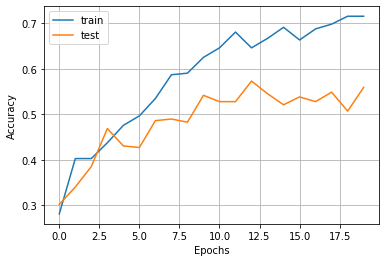

In [17]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.grid()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['train', 'test'])
plt.show()

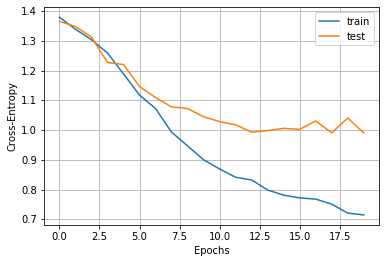

In [18]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid()
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy')
plt.legend(['train', 'test'])
plt.show()

In [19]:
probabilidades = model.predict(x_test)
y_pred = np.argmax(probabilidades, 1) #1=fila

In [20]:
kappa = cohen_kappa_score(y_test, y_pred)
print(kappa)

0.4120370370370371


In [21]:
matrizConfusion = confusion_matrix(y_test, y_pred)
print(matrizConfusion)

[[43 17  8  4]
 [26 41  4  1]
 [ 8  2 38 24]
 [10  3 20 39]]


In [22]:
reporteClassificacion = classification_report(y_test, y_pred)
print(reporteClassificacion)

              precision    recall  f1-score   support

           0       0.49      0.60      0.54        72
           1       0.65      0.57      0.61        72
           2       0.54      0.53      0.54        72
           3       0.57      0.54      0.56        72

   micro avg       0.56      0.56      0.56       288
   macro avg       0.57      0.56      0.56       288
weighted avg       0.57      0.56      0.56       288

